In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy

In [25]:
from src.prediction_functions import *
from src.config import *
from src.benchmark_functions import *

# Read in data

### Prior knowledge - ligand-receptor interactions from OmniPath

In [26]:
lig_rec = pd.read_csv(LIG_REC_DF, index_col = 0)

### TCGA - input data

In [27]:
tumors = [ f.path.split('/')[4] for f in os.scandir(TCGA_DATA_DIR) if f.is_dir() ]

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/SZILVIUSBC/TCGA/'

In [44]:
len(tumors)

33

In [45]:
tcga_rdata = pd.read_csv(f'{TCGA_DATA_DIR}/{tumors[0]}/rdata.csv', index_col = 0)
gene_name_map = tcga_rdata[['gene_id', 'gene_name']].set_index('gene_id')
gene_name_map = dict(gene_name_map.drop_duplicates()['gene_name'])

def map_gene_names(gex):
    gex_mapped = gex.copy()
    gex_mapped.index  = gex_mapped.index.map(gene_name_map)   
    return gex_mapped

def get_mean_of_same_gene_symbol(gex):
    return gex.reset_index().groupby('index').mean()
    

In [46]:

tcga_gex = {}
i = 0
print('total length:', len(tumors))
for tumor in tumors:
    print(i, end = ' ')
    tcga_gex[tumor] = pd.read_csv(f'{TCGA_DATA_DIR}/{tumor}/adata.csv', index_col = 0)
    tcga_gex[tumor] = map_gene_names(tcga_gex[tumor])
    tcga_gex[tumor] = get_mean_of_same_gene_symbol(tcga_gex[tumor])
    tcga_gex[tumor] = tcga_gex[tumor].T
    tcga_gex[tumor].index = [f"{sampleID}_{tumor}" for sampleID in tcga_gex[tumor].index]  # Append tissue type
    i += 1
all_genes = tcga_rdata.gene_name.unique()
all_samples = []
for tumor in tumors:
    all_samples.extend(tcga_gex[tumor].index)
merged = pd.DataFrame(columns = all_genes, index = all_samples, dtype=float)
for tumor in tumors:
    gex = tcga_gex[tumor]
    merged.loc[gex.index, gex.columns] = gex

total length: 33
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 

In [47]:
merged_log = np.log2(merged+1)

### CCLE - input data

In [63]:
ccle = pd.read_csv('data/ccle/OmicsExpressionProteinCodingGenesTPMLogp1.csv', index_col = 0)

In [64]:
ccle.columns = ccle.columns.str.split(' ', expand = True).get_level_values(0)

# Calculations

In [48]:
def get_cytokine_receptors(cytokine_activities, input_data, lincs_model):
    lig_rec_filtered = lig_rec[['source_genesymbol', 'target_genesymbol']].drop_duplicates().reset_index(drop = True).copy()
    ligs = cytokine_activities.columns[cytokine_activities.columns.isin(lig_rec_filtered.source_genesymbol)]
    receptors_of_cytokines = lig_rec_filtered[lig_rec_filtered.source_genesymbol.isin(ligs)]
    receptors_of_cytokines = receptors_of_cytokines[receptors_of_cytokines.target_genesymbol.isin(input_data.columns)].reset_index(drop = True)
    cytokine_list = list(set(receptors_of_cytokines.target_genesymbol) & set(input_data.columns) & set(lincs_model.columns))
    return cytokine_list

In [49]:
def calculate_correlations_receptorxligand(lig_rec, input_data_tpm, receptor_activities, zscore = False, rep = 10):
    print('Calculate correlations')
    gene_receptor_corr_tg = CorrelationsNotMean.receptor_activity_and_receptorxligand_correlation(lig_rec, input_data_tpm, receptor_activities, zscore)

    print('Calculate background correlation', end = ': ')
    correlation_perm = CorrelationsNotMean.background_correlation_receptor_ligandxreceptor_repeated(lig_rec, input_data_tpm, receptor_activities, repetition = rep)
    print('Preparing the data.')
    receptor_violin = pd.DataFrame.from_dict(gene_receptor_corr_tg ,orient ='index', columns = ['value'])
    receptor_violin['type'] = 'receptor'
    receptor_violin['source'] = 'original'

    correlation_perm_df = pd.DataFrame.from_dict(correlation_perm, orient ='index', columns = ['value'])
    correlation_perm_df['type'] = 'receptor'
    correlation_perm_df['source'] = 'random'

    return receptor_violin, correlation_perm_df

In [50]:
def calculate_correlations_receptor(lig_rec, input_data_tpm, receptor_activities, zscore = False, rep = 10):
    print('Calculate correlations')
    gene_receptor_corr_tg = CorrelationsNotMean.activity_and_gene_correlation(input_data_tpm, receptor_activities)

    print('Calculate background correlation', end = ': ')
    correlation_perm = CorrelationsNotMean.background_correlation_receptor_repeated(lig_rec, input_data_tpm, receptor_activities, repetition = rep)
    print('Preparing the data.')
    receptor_violin = pd.DataFrame.from_dict(gene_receptor_corr_tg ,orient ='index', columns = ['value'])
    receptor_violin['type'] = 'receptor'
    receptor_violin['source'] = 'original'

    correlation_perm_df = pd.DataFrame.from_dict(correlation_perm, orient ='index', columns = ['value'])
    correlation_perm_df['type'] = 'receptor'
    correlation_perm_df['source'] = 'random'

    return receptor_violin, correlation_perm_df

In [51]:
def calculate_correlations_ligand(lig_rec, input_data_tpm, receptor_activities, zscore = False, rep = 10):
    print('Calculate correlations')
    gene_receptor_corr_tg = CorrelationsNotMean.receptor_activity_ligand_correlation(lig_rec, input_data_tpm, receptor_activities)

    print('Calculate background correlation', end = ': ')
    correlation_perm = CorrelationsNotMean.background_correlation_receptor_ligand_repeated(lig_rec, input_data_tpm, receptor_activities, repetition = rep)
    print('Preparing the data.')
    receptor_violin = pd.DataFrame.from_dict(gene_receptor_corr_tg ,orient ='index', columns = ['value'])
    receptor_violin['type'] = 'receptor'
    receptor_violin['source'] = 'original'

    correlation_perm_df = pd.DataFrame.from_dict(correlation_perm, orient ='index', columns = ['value'])
    correlation_perm_df['type'] = 'receptor'
    correlation_perm_df['source'] = 'random'

    return receptor_violin, correlation_perm_df

### Receptor activities of CCLE

In [74]:
model_type = 'multipl'
model_name= 'all'
input_db = 'ccle'
input_data = ccle
print("Estimate receptor activities")
if model_type == 'multipl':
    lincs_model = pd.read_csv(f'data/coefficient_matrix/high_quality/{model_name}_pert_coef_liana.csv', index_col =0)
    receptor_activities = estimate_receptor_activity(input_data, lincs_model.T, number_of_permutations = 1000, chunk_size=300)
    print(receptor_activities.shape)


Estimate receptor activities
Number of samples: 1408
Number of chunks: 5
Number of permutations: 1000


100%|██████████| 5/5 [00:25<00:00,  5.13s/it]

(1408, 229)


In [75]:
receptor_activities.to_csv(f'results/validation/biological_relevance/all_ccle_receptor_activities.csv')

### CCLE expression correlations and random

In [76]:
input_data_tpm = ccle.copy()
print('receptorxligand')
receptor_violin_lxr_ccle, correlation_perm_df_lxr_ccle = calculate_correlations_receptorxligand(lig_rec, input_data_tpm, receptor_activities, zscore = False, rep = 100)
correlation_perm_df_lxr_ccle.to_csv(f'results/validation/biological_relevance/correlation_perm_df_lxr_ccle.csv')
receptor_violin_lxr_ccle.to_csv(f'results/validation/biological_relevance/receptor_violin_lxr_ccle.csv')

print('receptor')
input_data_tpm = ccle.copy()
receptor_violin_rec_ccle, correlation_perm_df_rec_ccle = calculate_correlations_receptor(lig_rec, input_data_tpm, receptor_activities, zscore = False, rep = 100)
receptor_violin_rec_ccle.to_csv(f'results/validation/biological_relevance/receptor_violin_rec_ccle.csv')
correlation_perm_df_rec_ccle.to_csv(f'results/validation/biological_relevance/correlation_perm_df_rec_ccle.csv')

input_data_tpm = ccle.copy()
print('ligand')
receptor_violin_lig_ccle, correlation_perm_df_lig_ccle = calculate_correlations_ligand(lig_rec, input_data_tpm, receptor_activities, zscore = False, rep = 100)
correlation_perm_df_lig_ccle.to_csv(f'results/validation/biological_relevance/correlation_perm_df_lig_ccle.csv')
receptor_violin_lig_ccle.to_csv(f'results/validation/biological_relevance/receptor_violin_lig_ccle.csv')


receptorxligand
Calculate correlations
Calculate background correlation: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 ... done
Preparing the data.
receptor
Calculate correlations
Calculate background correlation: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 ... done
Preparing the data.
ligand
Calculate correlations
Calculate background correlation: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 5

In [6]:
ccle_lxr_path = f'results/validation/biological_relevance/receptor_violin_lxr_ccle.csv'
ccle_lxr_rand_path = f'results/validation/biological_relevance/correlation_perm_df_lxr_ccle.csv'
ccle_rec_path = f'results/validation/biological_relevance/receptor_violin_rec_ccle.csv'
ccle_rec_rand_path = f'results/validation/biological_relevance/correlation_perm_df_rec_ccle.csv'
ccle_lig_path = f'results/validation/biological_relevance/receptor_violin_lig_ccle.csv'
ccle_lig_rand_path = f'results/validation/biological_relevance/correlation_perm_df_lig_ccle.csv'
# Ligand x Receptor TPM correlations with Receptor activity
ccle_lxr = pd.read_csv(ccle_lxr_path, index_col = 0)
ccle_lxr_rand = pd.read_csv(ccle_lxr_rand_path, index_col = 0)
# Receptor TPM correlations with Receptor activity
ccle_rec = pd.read_csv(ccle_rec_path, index_col = 0)
ccle_rec_rand = pd.read_csv(ccle_rec_rand_path, index_col = 0)
# Ligand TPM correlations with Receptor activity
ccle_lig = pd.read_csv(ccle_lig_path, index_col = 0)
ccle_lig_rand = pd.read_csv(ccle_lig_rand_path, index_col = 0)

In [13]:
def violinplot(receptor_violin:pd.DataFrame, background_correlation:pd.DataFrame, title = '', save_plot_pdf = False, filepath = '',  filename = ''):
    """Plot Violin and calculate Wilcoxon
    
    Parameters
    ----------
    receptor_violin : DataFrame
    background_correlation : DataFrame
    title : str
    save_plot_pdf : bool
    filepath : str
    filename : str
    """
    background_correlation_overlap = background_correlation.loc[background_correlation.index.isin(receptor_violin.index)].copy()
    violin = pd.concat([receptor_violin, background_correlation_overlap])
    # plot
    fig, ax = plt.subplots(figsize = (4,5))
    sns.violinplot(data = violin, y = 'value', x = 'type', hue = 'source', inner = 'quartile', palette= 'Blues')
    plt.axhline(0, color = 'k')
    plt.ylabel('Correlation')
    # wilcoxon receptor
    wilc = scipy.stats.wilcoxon(receptor_violin.value, background_correlation_overlap.value)
    r = round(wilc[0], 3)
    p = '{:.1e}'.format(wilc[1])
    text1 = 'Wilcoxon\ns='+str(r)+'\np='+str(p)
    # plot text
    plt.text(x = 0, y = receptor_violin.value.max()* 0.45, s = text1)
    plt.xlabel('')
    plt.ylabel('Correlation', fontsize = 12)
    plt.xticks(fontsize = 12)
    if title != '':
        plt.title(title)
    if save_plot_pdf == True:
        if filepath == '' or filename == '':
            raise ValueError('filepath or filename is missing')
        plt.savefig(f'{filepath}/{filename}.pdf', bbox_inches = 'tight', transparent = True)
    plt.show()

In [14]:
# # mean correlation
# def calculate_mean_correaltion_of_receptor(receptor_corr_data, random_corr_data):
#     receptor_corr_data_mean = receptor_corr_data.dropna().copy()
#     receptor_corr_data_mean.index = receptor_corr_data_mean.index.str.split('_', expand = True)
#     receptor_corr_data_mean = receptor_corr_data_mean.reset_index().groupby('level_0').mean()
#     receptor_corr_data_mean['type'] = 'receptor'
#     receptor_corr_data_mean['source'] = 'original'

#     random_corr_data_mean = random_corr_data.dropna().copy()
#     random_corr_data_mean.index = random_corr_data_mean.index.str.split('_', expand = True)
#     random_corr_data_mean = random_corr_data_mean.reset_index().groupby('level_0').mean()
#     random_corr_data_mean['type'] = 'receptor'
#     random_corr_data_mean['source'] = 'random'

#     return receptor_corr_data_mean, random_corr_data_mean


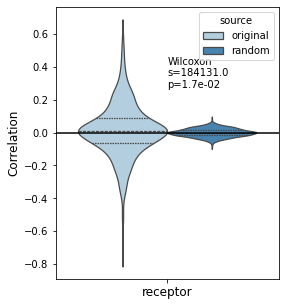

In [15]:
violinplot(ccle_lxr.dropna(), ccle_lxr_rand.dropna(), title = '', save_plot_pdf = False, filepath = f'figures/validation/biological_relevance/', filename = 'ccle_receptor_violin_ligandxreceptor')

### TCGA receptor activities

In [54]:
model_type = 'multipl'
model_name= 'all'
input_db = 'tcga'
input_data = merged_log
print("Estimate receptor activities")
if model_type == 'multipl':
    lincs_model = pd.read_csv(f'data/coefficient_matrix/high_quality/{model_name}_pert_coef_liana.csv', index_col =0)
    receptor_activities = estimate_receptor_activity(input_data, lincs_model.T, number_of_permutations = 1000, chunk_size=300)
    print(receptor_activities.shape)


Estimate receptor activities
Number of samples: 11274
Number of chunks: 38
Number of permutations: 1000


100%|██████████| 38/38 [03:22<00:00,  5.33s/it]

(11274, 229)


In [55]:
# receptor_activities.to_csv(f'results/validation/biological_relevance/all_tcga_receptor_activities.csv')

### TCGA correlations and random

In [66]:
input_data_tpm = merged_log.copy()
print('ligand')
receptor_violin_lig_tcga, correlation_perm_df_lig_tcga = calculate_correlations_ligand(lig_rec, input_data_tpm, receptor_activities, zscore = False, rep = 100)
correlation_perm_df_lig_tcga.to_csv(f'results/validation/biological_relevance/correlation_perm_df_lig_tcga_log.csv')
receptor_violin_lig_tcga.to_csv(f'results/validation/biological_relevance/receptor_violin_lig_tcga_log.csv')


ligand
Calculate correlations
Calculate background correlation: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 ... done
Preparing the data.


In [70]:
input_data_tpm = merged_log.copy()
print('receptorxligand')
receptor_violin_lxr_tcga, correlation_perm_df_lxr_tcga = calculate_correlations_receptorxligand(lig_rec, input_data_tpm, receptor_activities, zscore = False, rep = 100)
correlation_perm_df_lxr_tcga.to_csv(f'results/validation/biological_relevance/correlation_perm_df_lxr_tcga_log.csv')
receptor_violin_lxr_tcga.to_csv(f'results/validation/biological_relevance/receptor_violin_lxr_tcga_log.csv')

print('receptor')
input_data_tpm = merged_log.copy()
receptor_violin_rec_tcga, correlation_perm_df_rec_tcga = calculate_correlations_receptor(lig_rec, input_data_tpm, receptor_activities, zscore = False, rep = 100)
receptor_violin_rec_tcga.to_csv(f'results/validation/biological_relevance/receptor_violin_rec_tcga_log.csv')
correlation_perm_df_rec_tcga.to_csv(f'results/validation/biological_relevance/correlation_perm_df_rec_tcga_log.csv')


receptorxligand
Calculate correlations
Calculate background correlation: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 ... done
Preparing the data.
receptor
Calculate correlations
Calculate background correlation: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 ... done
Preparing the data.


In [38]:
tcga_lxr_path = f'results/validation/biological_relevance/receptor_violin_lxr_tcga_log.csv'
tcga_lxr_rand_path = f'results/validation/biological_relevance/correlation_perm_df_lxr_tcga_log.csv'
tcga_rec_path = f'results/validation/biological_relevance/receptor_violin_rec_tcga.csv'
tcga_rec_rand_path = f'results/validation/biological_relevance/correlation_perm_df_rec_tcga.csv'
tcga_lig_path = f'results/validation/biological_relevance/receptor_violin_lig_tcga_log.csv'
tcga_lig_rand_path = f'results/validation/biological_relevance/correlation_perm_df_lig_tcga_log.csv'
# Ligand x Receptor TPM correlations with Receptor activity
tcga_lxr = pd.read_csv(tcga_lxr_path, index_col = 0)
tcga_lxr_rand = pd.read_csv(tcga_lxr_rand_path, index_col = 0)
# # Receptor TPM correlations with Receptor activity
tcga_rec = pd.read_csv(tcga_rec_path, index_col = 0)
tcga_rec_rand = pd.read_csv(tcga_rec_rand_path, index_col = 0)
# Ligand TPM correlations with Receptor activity
tcga_lig = pd.read_csv(tcga_lig_path, index_col = 0)
tcga_lig_rand = pd.read_csv(tcga_lig_rand_path, index_col = 0)

In [48]:
tcga_lxr = tcga_lxr.dropna()
tcga_lxr_rand = tcga_lxr_rand.dropna()
tcga_lxr_rand = tcga_lxr_rand.loc[tcga_lxr_rand.index.isin(tcga_lxr.index)].copy()
wilc = scipy.stats.wilcoxon(tcga_lxr.value, tcga_lxr_rand.value)
r = round(wilc[0], 3)
p = '{:.1e}'.format(wilc[1])

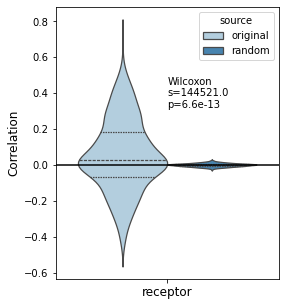

In [20]:
violinplot(tcga_lxr.dropna(), tcga_lxr_rand.dropna(), title = '', save_plot_pdf = False)